## インストール

In [1]:
!pip install yahoo_finance_api2 --quiet

  Preparing metadata (setup.py) ... done


# ダミーデータ生成（ランダムで推移）

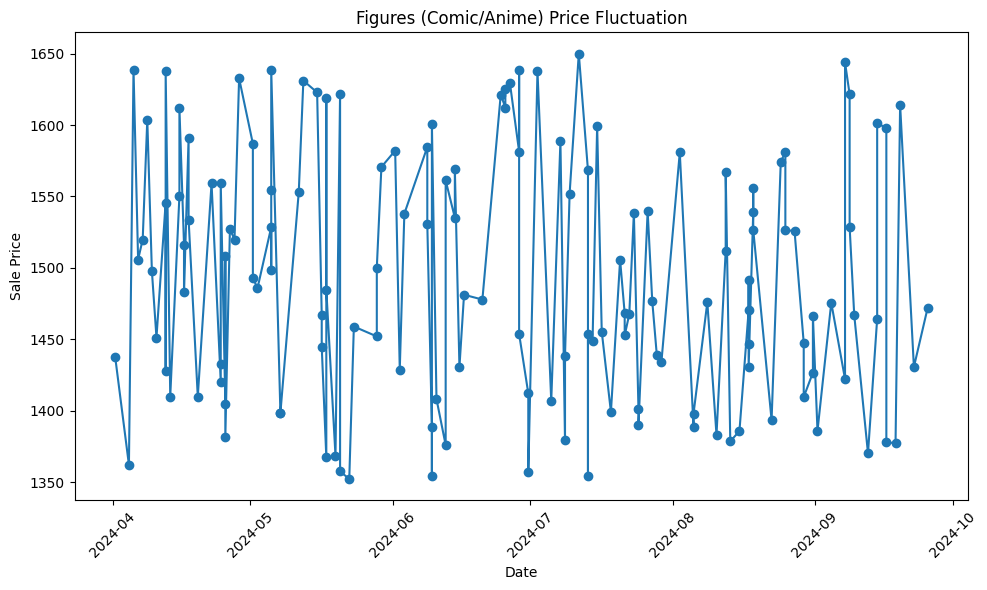


Top Trending Items in USA:
Plush Toys: Sale Price increased by 7.40%
Figures (Comic/Anime): Sale Price increased by 5.51%
Idol Goods: Sale Price increased by 3.42%

Top Trending Items in Japan:
Idol Goods: Sale Price increased by 5.45%
Pokemon Cards: Sale Price increased by 2.66%
Ladies’ Bags: Sale Price increased by 2.39%

Top Trending Items in UK:
Character Keychains: Sale Price increased by 8.37%
Ladies’ Bags: Sale Price increased by 6.44%
Idol Goods: Sale Price increased by 3.06%

Top Trending Items in Germany:
Ladies’ Bags: Sale Price increased by 3.68%
Idol Goods: Sale Price increased by 3.40%
Character Keychains: Sale Price increased by 1.87%

Top Trending Items in China:
Idol Goods: Sale Price increased by 5.19%
Pokemon Cards: Sale Price increased by 3.79%
Plush Toys: Sale Price increased by 3.39%

Top Trending Items in Australia:
Plush Toys: Sale Price increased by 3.48%
Pokemon Cards: Sale Price increased by 1.39%
Acrylic Stands: Sale Price increased by 0.58%

Top Trending I

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 英字アイテムリストと割合に基づく取引件数の分布
items = [
    'Pins/Badges', 'Figures (Comic/Anime)', 'Plush Toys', 'Acrylic Stands',
    'Digital Camera', 'K-POP/Asia Goods', 'Idol Goods', 'Character Keychains',
    'Ladies’ Bags', 'Pokemon Cards'
]
item_probabilities = [0.18, 0.15, 0.12, 0.1, 0.1, 0.08, 0.07, 0.07, 0.07, 0.06]

# 国のリスト
countries = ['USA', 'Japan', 'UK', 'Germany', 'China', 'Australia', 'Canada']

# 過去6ヶ月間の日付を生成
date_range = pd.date_range(end=pd.Timestamp.today(), periods=180).to_pydatetime().tolist()

num_records = 1000  # 取引件数

# ダミーデータの作成
np.random.seed(0)
data = {
    'Date': np.random.choice(date_range, size=num_records),
    'Item': np.random.choice(items, size=num_records, p=item_probabilities),
    'Buyer Country': np.random.choice(countries, size=num_records),
    'Seller Country': np.random.choice(countries, size=num_records),
    'Sale Price': np.zeros(num_records),
    'Purchase Price': np.zeros(num_records),
}

# 品物ごとの基準価格を設定
base_prices = {
    'Pins/Badges': 300,
    'Figures (Comic/Anime)': 1500,
    'Plush Toys': 1000,
    'Acrylic Stands': 800,
    'Digital Camera': 50000,
    'K-POP/Asia Goods': 1200,
    'Idol Goods': 2500,
    'Character Keychains': 500,
    'Ladies’ Bags': 15000,
    'Pokemon Cards': 1000
}

# 売却値段と購入値段を生成
for i in range(num_records):
    item = data['Item'][i]
    base_price = base_prices[item]
    # 基準価格の±20%で値段を設定
    sell_price = base_price * np.random.uniform(0.9, 1.1)
    purchase_price = sell_price * np.random.uniform(0.8, 0.95)  # 購入値段は売却値段より低い
    data['Sale Price'][i] = round(sell_price, 2)
    data['Purchase Price'][i] = round(purchase_price, 2)

# データフレームの作成
df = pd.DataFrame(data)

# 価格変動を可視化する関数
def visualize_price_fluctuation(item_name):
    # 指定された品物のデータを抽出
    df_item = df[df['Item'] == item_name]
    # 日付順にソート
    df_item = df_item.sort_values(by='Date')
    # 売却値段をプロット
    plt.figure(figsize=(10, 6))
    plt.plot(df_item['Date'], df_item['Sale Price'], marker='o', linestyle='-')
    plt.title(f'{item_name} Price Fluctuation')
    plt.xlabel('Date')
    plt.ylabel('Sale Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 流行っている品物をレコメンドする関数
def recommend_trending_items():
    # データを過去と最近の2つの期間に分割
    df['Date'] = pd.to_datetime(df['Date'])
    median_date = df['Date'].median()
    df_recent = df[df['Date'] >= median_date]
    df_past = df[df['Date'] < median_date]

    trending_items = {}

    for country in countries:
        df_recent_country = df_recent[df_recent['Seller Country'] == country]
        df_past_country = df_past[df_past['Seller Country'] == country]

        recent_prices = df_recent_country.groupby('Item')['Sale Price'].mean()
        past_prices = df_past_country.groupby('Item')['Sale Price'].mean()

        price_change = ((recent_prices - past_prices) / past_prices) * 100
        price_change = price_change.dropna().sort_values(ascending=False)
        trending_items[country] = price_change.head(3)  # 上位3つの品物

    # 国ごとの流行アイテムを表示
    for country in trending_items:
        print(f'\nTop Trending Items in {country}:')
        for item, change in trending_items[country].items():
            print(f'{item}: Sale Price increased by {change:.2f}%')

# 使用例:

# 品物の価格変動を可視化
visualize_price_fluctuation('Figures (Comic/Anime)')

# 流行っている品物をレコメンド
recommend_trending_items()


# ダミーデータ作成（yfinanceから為替データ取ってる）

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta

# Function to fetch exchange rate data (daily data for the past 1 year)
def get_fx_data(ticker, period="1y", interval="1d"):
    try:
        fx_data = yf.download(ticker, period=period, interval=interval)['Close']
        fx_data = fx_data.sort_index()
        return fx_data  # Get closing prices
    except Exception as e:
        print(f"Error fetching exchange rate data for {ticker}: {e}")
        return None

# List of countries (Japan, Southeast Asia, East Asia)
countries = ['Japan', 'China', 'South Korea', 'Vietnam', 'Thailand', 'Malaysia', 'Indonesia', 'Philippines']

# Currency tickers for each country (against USD)
currency_tickers = {
    'Japan': 'JPY=X',
    'China': 'CNY=X',
    'South Korea': 'KRW=X',
    'Vietnam': 'VND=X',
    'Thailand': 'THB=X',
    'Malaysia': 'MYR=X',
    'Indonesia': 'IDR=X',
    'Philippines': 'PHP=X'
}

# Currency codes mapping
currency_codes = {
    'Japan': 'JPY',
    'China': 'CNY',
    'South Korea': 'KRW',
    'Vietnam': 'VND',
    'Thailand': 'THB',
    'Malaysia': 'MYR',
    'Indonesia': 'IDR',
    'Philippines': 'PHP'
}

# Fetch exchange rate data
fx_data_dict = {}
for country, ticker in currency_tickers.items():
    fx_data = get_fx_data(ticker)
    if fx_data is not None:
        currency_code = currency_codes[country]  # Use currency code as key
        fx_data_dict[currency_code] = fx_data
        print(f"Fetched exchange rate data for {currency_code}: {fx_data.tail()}")

# List of items and their base prices in JPY
items = {
    'Pins/Badges': 300,
    'Figures (Comic/Anime)': 1500,
    'Plush Toys': 1000,
    'Acrylic Stands': 800,
    'Digital Camera': 50000,
    'K-POP/Asia Goods': 1200,
    'Idol Goods': 2500,
    'Character Keychains': 500,
    'Ladies’ Bags': 15000,
    'Pokemon Cards': 1000
}

# Generate dates for the past 1 year
date_range = pd.date_range(end=pd.Timestamp.today(), periods=365)

# Set maximum and minimum prices
MAX_PRICE = 650000  # Maximum price in JPY
MIN_PRICE = 10      # Minimum price in JPY

# Initialize lists to collect data
data_records = []

np.random.seed(0)  # For reproducibility

# Number of transactions per item per country
transactions_per_item_country = 50

for country in countries:
    seller_currency_code = currency_codes[country]
    for item_name, base_price_jpy in items.items():
        # Generate transaction dates for this item in this country
        transaction_dates = np.random.choice(date_range, size=transactions_per_item_country, replace=False)
        transaction_dates = np.sort(transaction_dates)  # Ensure dates are sorted

        # Initialize sale price list
        sale_prices_jpy = []

        # Generate sale prices with fluctuations
        for i, date in enumerate(transaction_dates):
            if i == 0:
                # First price is base price
                sale_price_jpy = base_price_jpy
            else:
                # Adjust price by ±30%
                prev_price = sale_prices_jpy[-1]
                sale_price_jpy = prev_price * np.random.uniform(0.7, 1.3)
                # Ensure sale price is within MIN_PRICE and MAX_PRICE
                sale_price_jpy = min(max(sale_price_jpy, MIN_PRICE), MAX_PRICE)
            sale_prices_jpy.append(sale_price_jpy)

        # Generate purchase prices (80% to 95% of sale price)
        purchase_prices_jpy = [price * np.random.uniform(0.8, 0.95) for price in sale_prices_jpy]

        # Assign buyer countries randomly
        buyer_countries = np.random.choice(countries, size=transactions_per_item_country)

        for i in range(transactions_per_item_country):
            date = transaction_dates[i]
            sale_price_jpy = sale_prices_jpy[i]
            purchase_price_jpy = purchase_prices_jpy[i]
            buyer_country = buyer_countries[i]
            buyer_currency_code = currency_codes[buyer_country]

            # Collect data record
            record = {
                'Date': date,
                'Item': item_name,
                'Buyer Country': buyer_country,
                'Seller Country': country,
                'Sale Price': sale_price_jpy,  # In JPY
                'Purchase Price': purchase_price_jpy,  # In JPY
                'Sale Currency': seller_currency_code,
                'Purchase Currency': buyer_currency_code,
                'Product Description': 'This is a sample product description.',
                'Product Image': 'image_path.jpg'
            }
            data_records.append(record)

# Create DataFrame
df = pd.DataFrame(data_records)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by 'Item', 'Date', and 'Seller Country'
df = df.sort_values(by=['Item', 'Date', 'Seller Country']).reset_index(drop=True)

# Create an exchange rate DataFrame
all_dates = np.sort(df['Date'].unique())  # Corrected line

fx_rates_df = pd.DataFrame(index=all_dates)

for curr in currency_codes.values():
    if curr == 'JPY':
        fx_rates_df[f'FX JPY to {curr}'] = 1.0
    else:
        fx_curr_series = fx_data_dict[curr]
        fx_jpy_series = fx_data_dict['JPY']

        # Combine exchange rates into a DataFrame
        fx_combined = pd.DataFrame({
            f'FX {curr} per USD': fx_curr_series,
            'FX JPY per USD': fx_jpy_series
        })

        # Calculate exchange rate from JPY to curr
        fx_combined[f'FX JPY to {curr}'] = fx_combined[f'FX {curr} per USD'] / fx_combined['FX JPY per USD']

        # Reindex to include all dates, forward-fill missing values
        fx_combined = fx_combined.reindex(all_dates, method='ffill')

        # Add exchange rate to fx_rates_df
        fx_rates_df[f'FX JPY to {curr}'] = fx_combined[f'FX JPY to {curr}']

# Merge exchange rates with the main DataFrame
df = df.merge(fx_rates_df, left_on='Date', right_index=True, how='left')

# Initialize columns for converted prices
for curr in currency_codes.values():
    df[f'Sale Price in {curr}'] = df['Sale Price'] * df[f'FX JPY to {curr}']
    df[f'Purchase Price in {curr}'] = df['Purchase Price'] * df[f'FX JPY to {curr}']

# Display the first few rows of the DataFrame
print(df.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched exchange rate data for JPY: Date
2024-09-20    142.858002
2024-09-23    144.003998
2024-09-24    143.638000
2024-09-25    142.962997
2024-09-26    144.792007
Name: Close, dtype: float64
Fetched exchange rate data for CNY: Date
2024-09-20    7.0670
2024-09-23    7.0509
2024-09-24    7.0513
2024-09-25    7.0302
2024-09-26    7.0157
Name: Close, dtype: float64
Fetched exchange rate data for KRW: Date
2024-09-20    1327.609985
2024-09-23    1331.500000
2024-09-24    1333.619995
2024-09-25    1324.890015
2024-09-26    1328.170044
Name: Close, dtype: float64
Fetched exchange rate data for VND: Date
2024-09-20    24565.0
2024-09-23    24590.0
2024-09-24    24615.0
2024-09-25    24590.0
2024-09-26    24420.0
Name: Close, dtype: float64


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched exchange rate data for THB: Date
2024-09-20    33.110001
2024-09-23    32.959999
2024-09-24    32.919998
2024-09-25    32.563000
2024-09-26    32.650002
Name: Close, dtype: float64
Fetched exchange rate data for MYR: Date
2024-09-20    4.2115
2024-09-23    4.2025
2024-09-24    4.2005
2024-09-25    4.1500
2024-09-26    4.1250
Name: Close, dtype: float64
Fetched exchange rate data for IDR: Date
2024-09-20    15197.599609
2024-09-23    15154.000000
2024-09-24    15174.099609
2024-09-25    15121.099609
2024-09-26    15180.000000
Name: Close, dtype: float64
Fetched exchange rate data for PHP: Date
2024-09-20    55.449001
2024-09-23    55.630001
2024-09-24    55.938999
2024-09-25    55.875000
2024-09-26    55.980000
Name: Close, dtype: float64
                        Date            Item Buyer Country Seller Country  \
0 2023-09-29 05:36:58.122251  Acrylic Stands       Vietnam          China   
1 2023-09-29 05:36:58.122251  Acrylic Stands         Japan    South Korea   
2 2023-09-30 

In [54]:
df.head(60)

,Date,Item,Buyer Country,Seller Country,Sale Price,Purchase Price,Sale Currency,Purchase Currency,Product Description,Product Image,...,Sale Price in VND,Purchase Price in VND,Sale Price in THB,Purchase Price in THB,Sale Price in MYR,Purchase Price in MYR,Sale Price in IDR,Purchase Price in IDR,Sale Price in PHP,Purchase Price in PHP
0,2023-09-29 05:36:58.122251,Acrylic Stands,Vietnam,China,800.000000,697.283438,CNY,VND,This is a sample product description.,image_path.jpg,...,130630.716209,113858.293666,195.884479,170.733754,25.210094,21.973226,82894.390101,72251.106671,303.410399,264.453807
1,2023-09-29 05:36:58.122251,Acrylic Stands,Japan,South Korea,800.000000,744.833561,KRW,JPY,This is a sample product description.,image_path.jpg,...,130630.716209,121622.676896,195.884479,182.376667,25.210094,23.471655,82894.390101,77178.154697,303.410399,282.487809
2,2023-09-30 05:36:58.122251,Acrylic Stands,Indonesia,Indonesia,800.000000,739.734141,IDR,IDR,This is a sample product description.,image_path.jpg,...,130630.716209,120790.000814,195.884479,181.128046,25.210094,23.310959,82894.390101,76649.763076,303.410399,280.553788
3,2023-10-01 05:36:58.122251,Acrylic Stands,Vietnam,China,815.246431,765.452736,CNY,VND,This is a sample product description.,image_path.jpg,...,133120.281464,124989.548923,199.617653,187.425388,25.690548,24.121419,84474.194602,79314.672136,309.192806,290.307900
4,2023-10-01 05:36:58.122251,Acrylic Stands,Malaysia,Malaysia,800.000000,688.786251,MYR,MYR,This is a sample product description.,image_path.jpg,...,130630.716209,112470.801651,195.884479,168.653170,25.210094,21.705457,82894.390101,71370.645263,303.410399,261.231139
5,2023-10-03 05:36:58.122251,Acrylic Stands,Thailand,China,872.322674,750.205397,CNY,THB,This is a sample product description.,image_path.jpg,...,141689.639523,121854.372760,215.526580,185.354810,27.444363,23.602401,90322.779246,77678.407878,330.438401,284.180017
6,2023-10-03 05:36:58.122251,Acrylic Stands,Vietnam,Malaysia,854.326367,686.023193,MYR,VND,This is a sample product description.,image_path.jpg,...,138766.535121,111429.384817,211.080195,169.497180,26.878177,21.583148,88459.390260,71032.799294,323.621347,259.867609
7,2023-10-03 05:36:58.122251,Acrylic Stands,China,Philippines,800.000000,657.996710,PHP,CNY,This is a sample product description.,image_path.jpg,...,129942.411260,106877.098936,197.657667,162.572618,25.169001,20.701400,82834.283201,68130.857317,303.042359,249.251094
8,2023-10-05 05:36:58.122251,Acrylic Stands,Philippines,Thailand,800.000000,748.227313,THB,PHP,This is a sample product description.,image_path.jpg,...,131144.016432,122656.918840,198.251948,185.421903,25.396399,23.752849,83729.171179,78310.565997,304.010310,284.336022
9,2023-10-06 05:36:58.122251,Acrylic Stands,Philippines,China,1044.444695,973.211558,CNY,PHP,This is a sample product description.,image_path.jpg,...,171514.532858,159816.911969,259.839602,242.118042,33.240613,30.973540,109964.875435,102465.059516,398.401952,371.230173


In [55]:
df.to_csv('dummy_data.csv', index=False)

In [9]:
# prompt: APIを作りたい．Itemを指定されたらDate，Sale Priceをjson形式で返す関数を作って

import json

def get_item_price_history(item_name):
  """
  指定されたアイテムの日付と販売価格の履歴をJSON形式で返します。

  Args:
    item_name: アイテム名。

  Returns:
    JSON形式のアイテムの価格履歴。
  """
  try:
    df_item = df[df['Item'] == item_name].copy()
    df_item = df_item[['Date', 'Sale Price']].sort_values('Date')

    # Pandas DataFrameを辞書のリストに変換
    price_history = df_item.to_dict('records')

    # JSONに変換
    return json.dumps(price_history)
  except Exception as e:
    print(f"Error fetching price history: {e}")
    return json.dumps({'error': 'Failed to fetch price history'})


# 使用例
item_name = 'Figures (Comic/Anime)'
price_history_json = get_item_price_history(item_name)
print(price_history_json)


Error fetching price history: Object of type Timestamp is not JSON serializable
{"error": "Failed to fetch price history"}


# 可視化，LLMによる売買レコメンド，

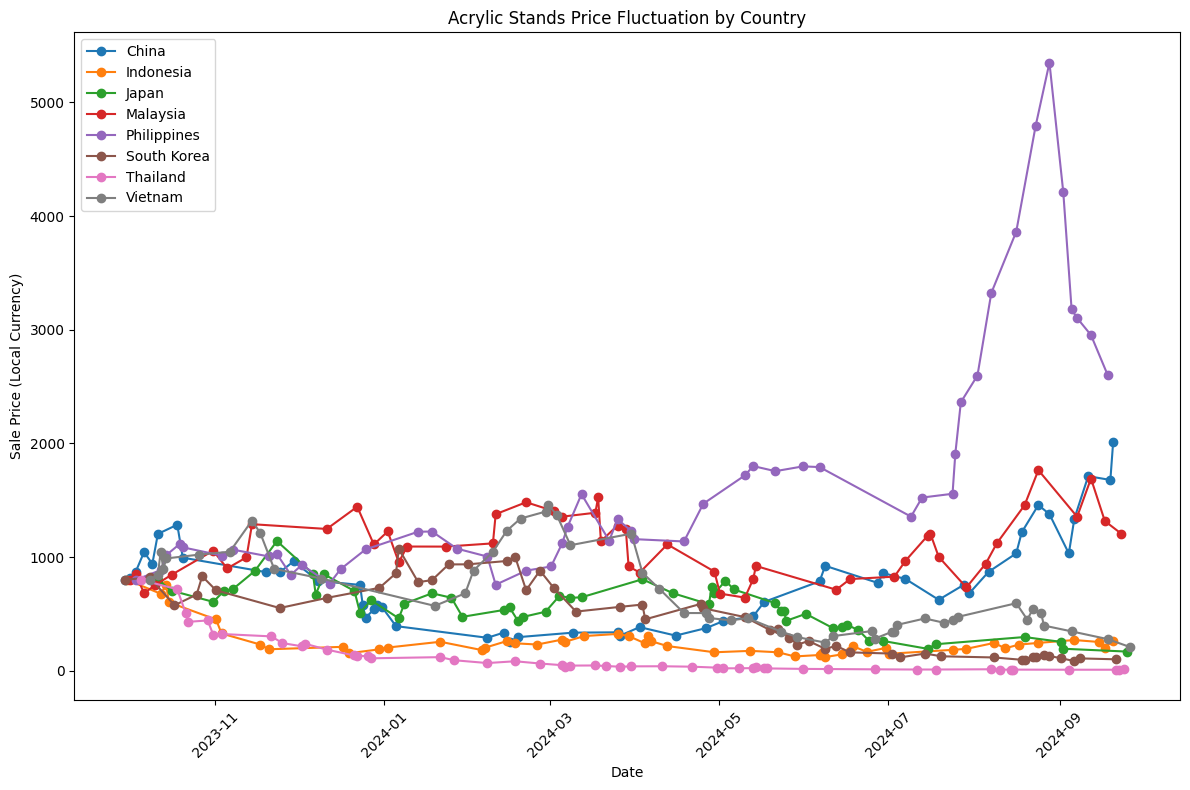


Top Trending Items in Japan:
Idol Goods: Sale Price increased by 132.87%


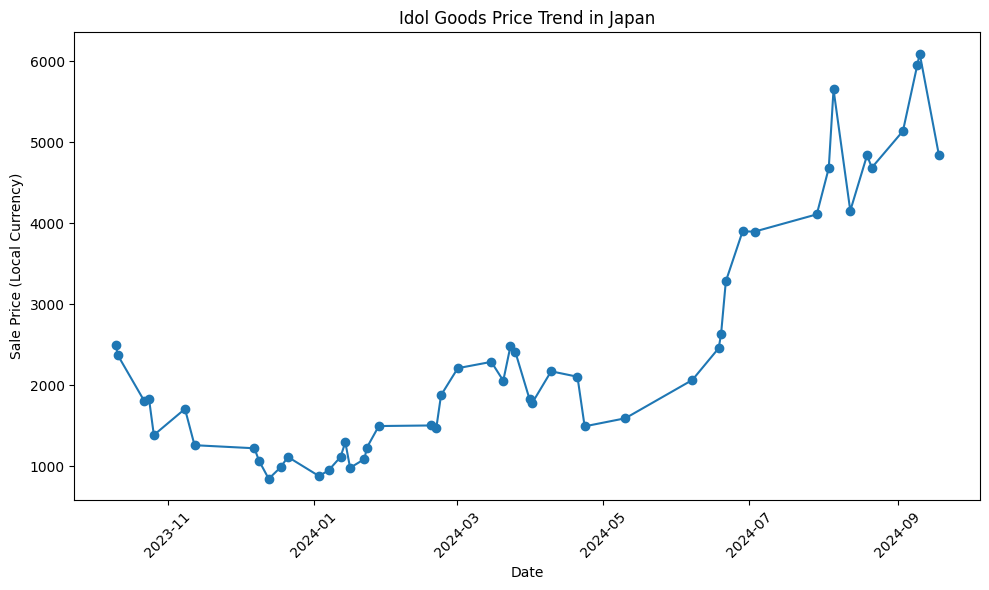

Pins/Badges: Sale Price increased by 22.16%


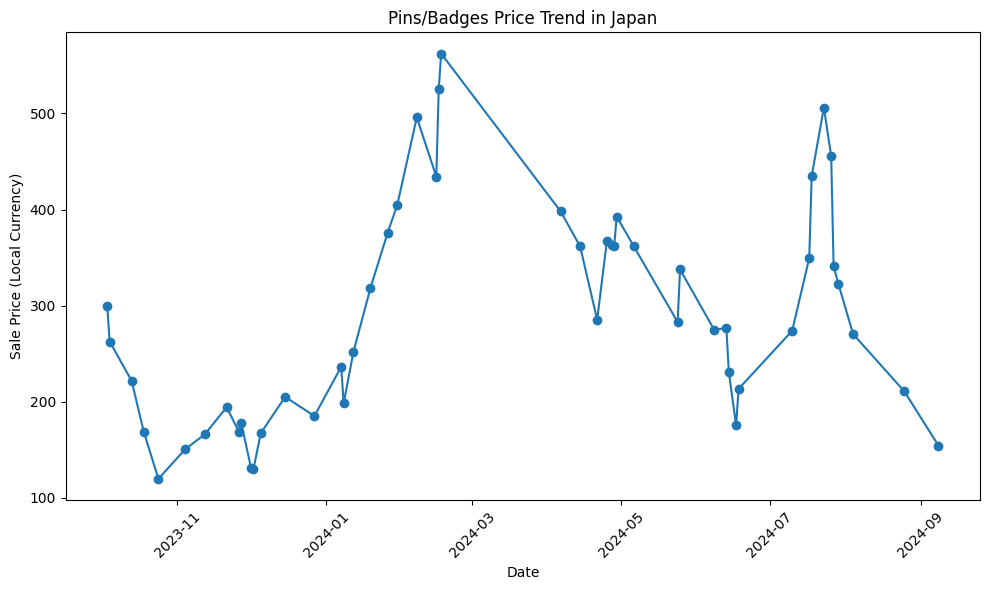

Ladies’ Bags: Sale Price increased by 15.93%


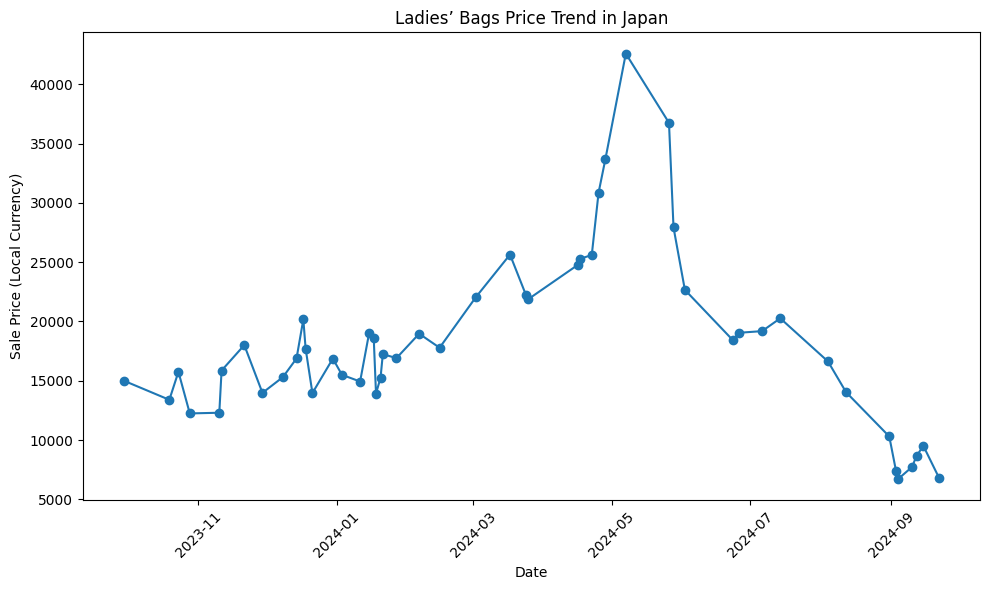


Top Trending Items in China:
Character Keychains: Sale Price increased by 375.84%


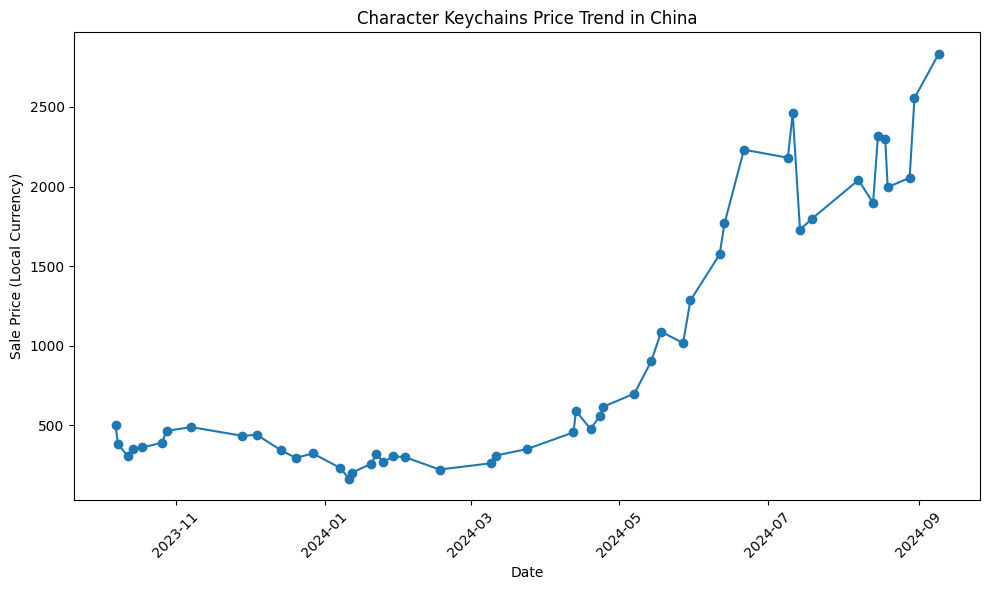

Acrylic Stands: Sale Price increased by 39.68%


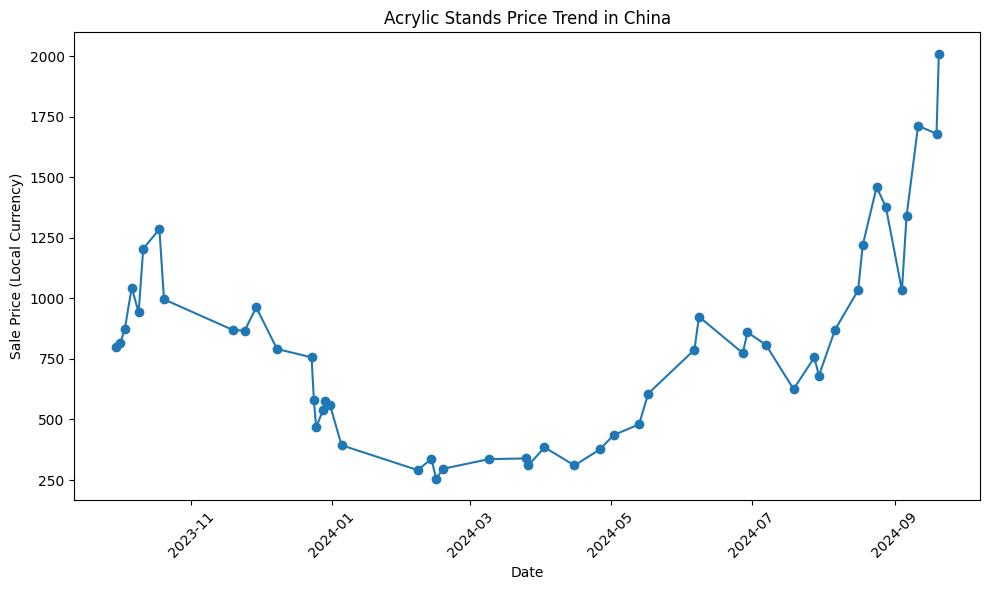

Figures (Comic/Anime): Sale Price increased by 17.33%


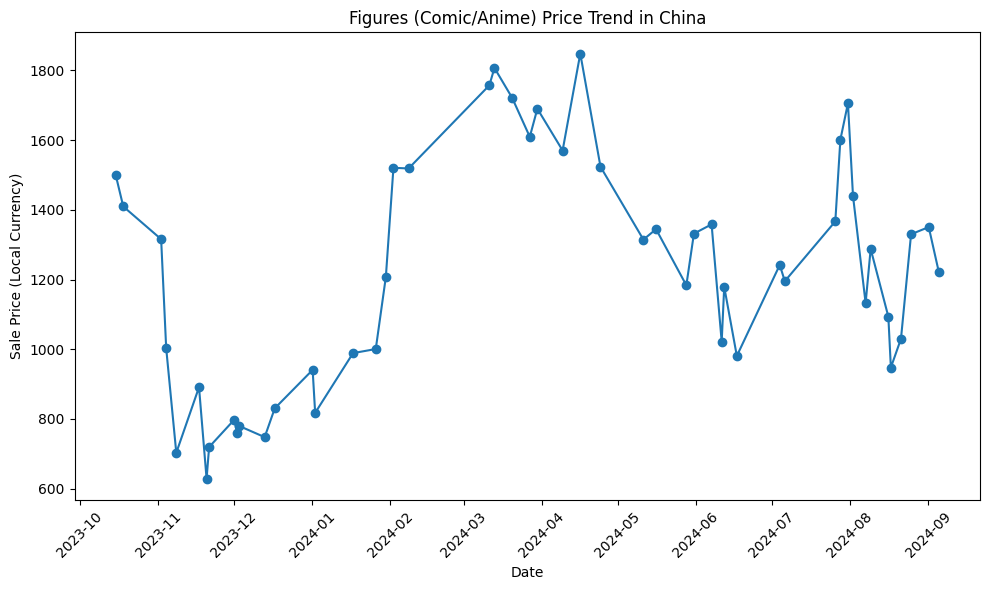


Top Trending Items in South Korea:
Pins/Badges: Sale Price increased by 134.67%


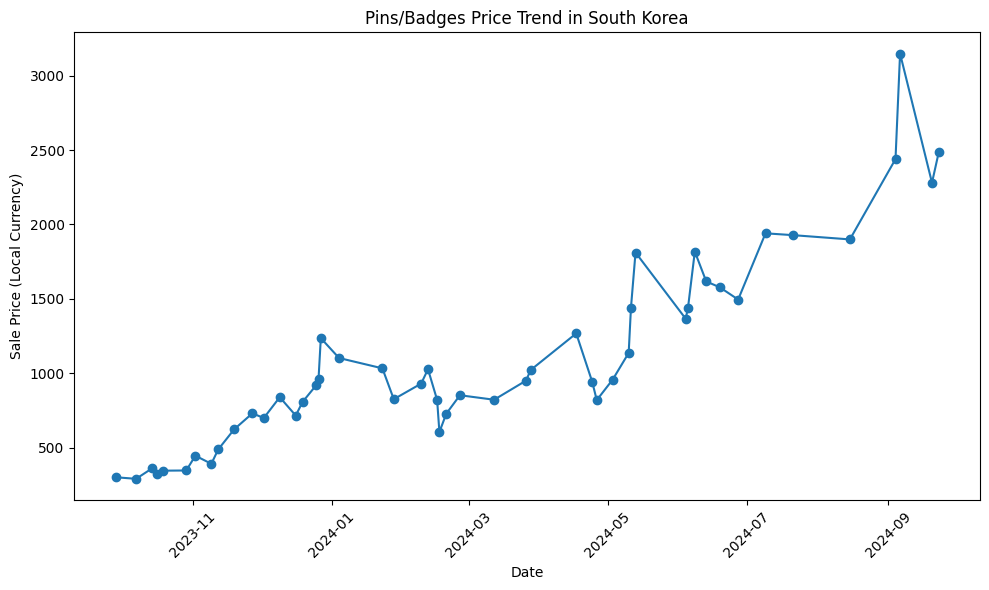

Figures (Comic/Anime): Sale Price increased by 107.64%


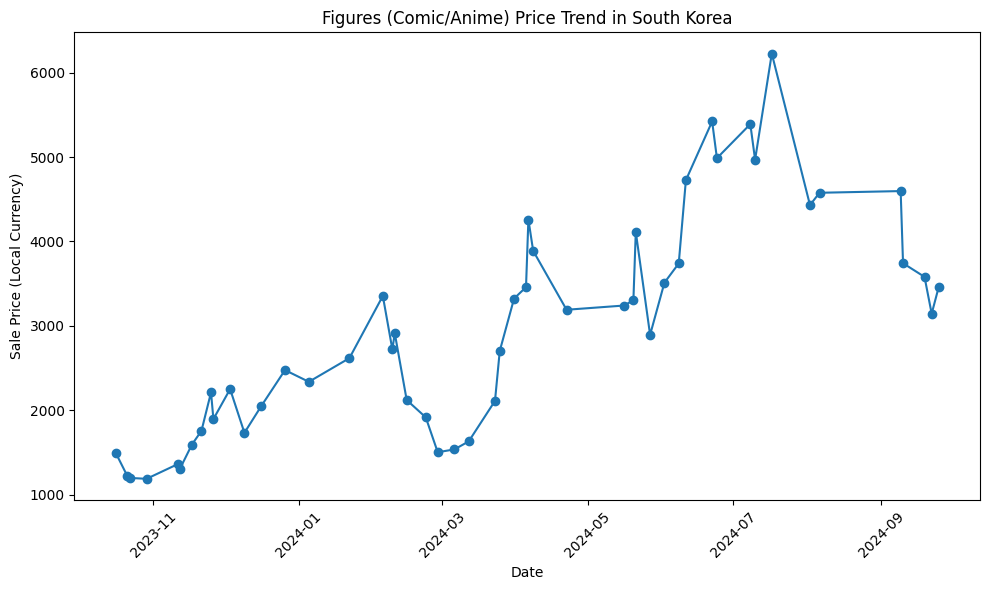

Ladies’ Bags: Sale Price increased by 99.13%


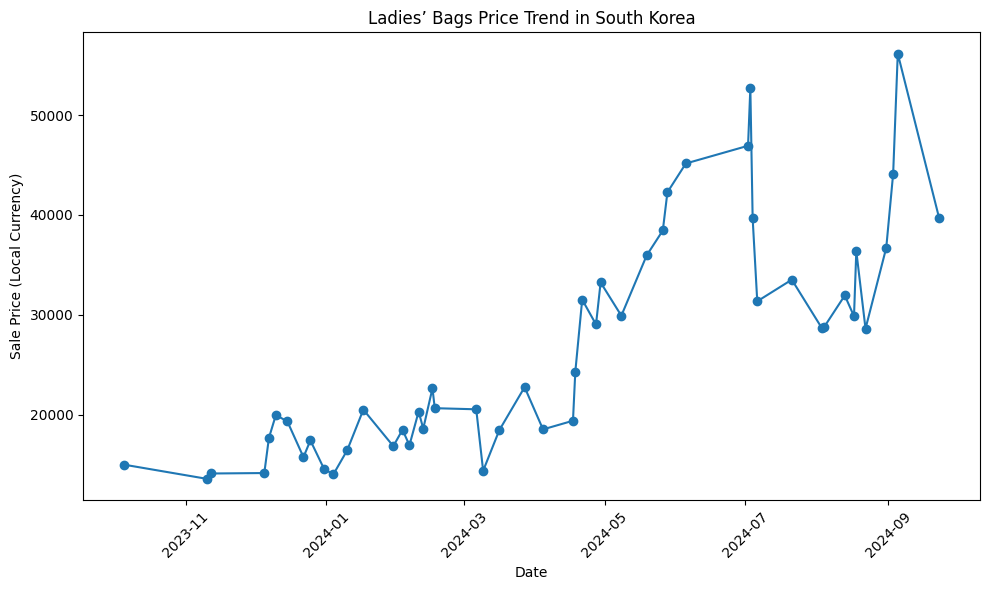


Top Trending Items in Vietnam:
K-POP/Asia Goods: Sale Price increased by 96.64%


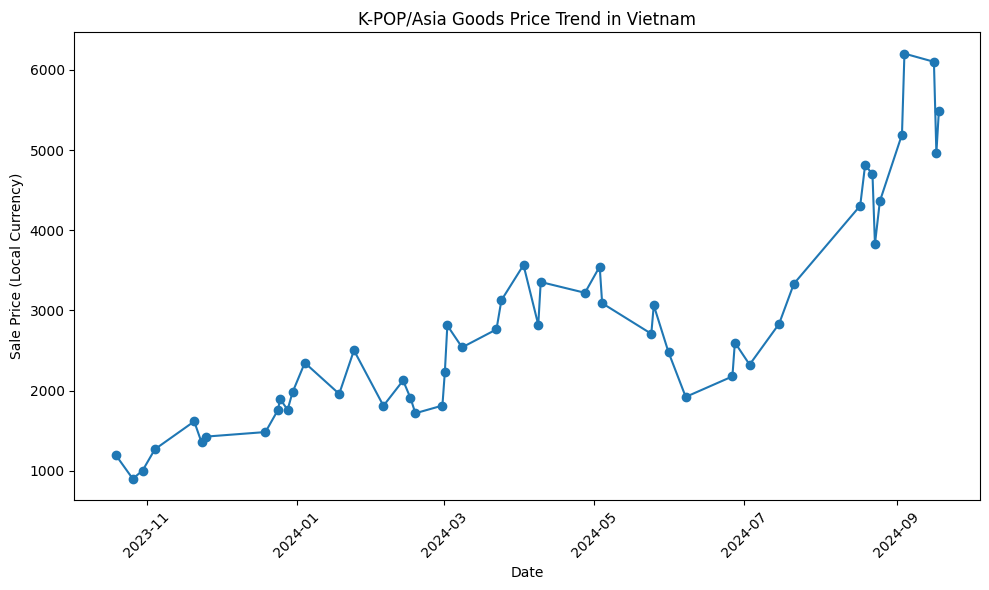

Character Keychains: Sale Price increased by 48.70%


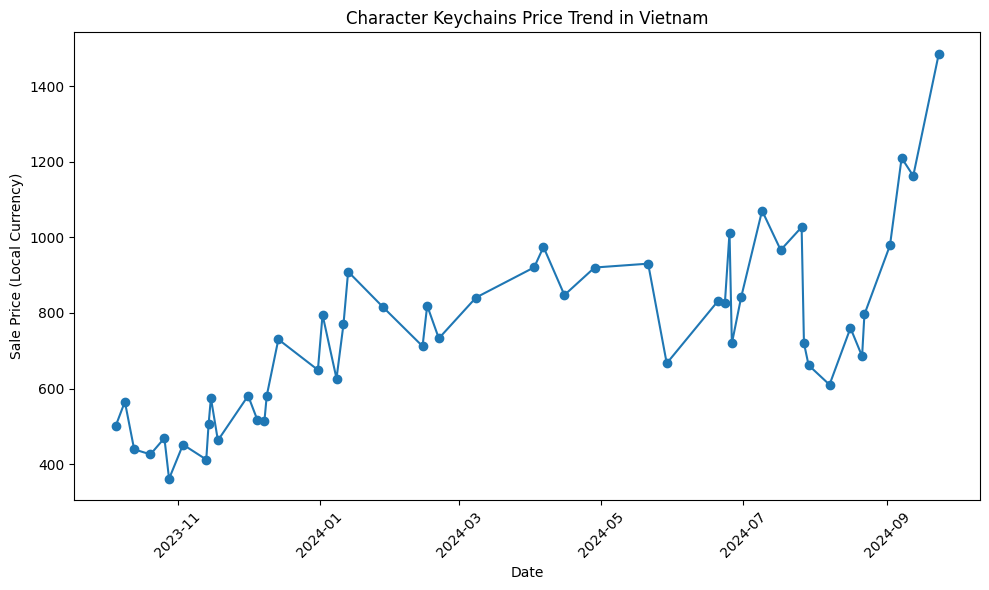

Idol Goods: Sale Price increased by 7.04%


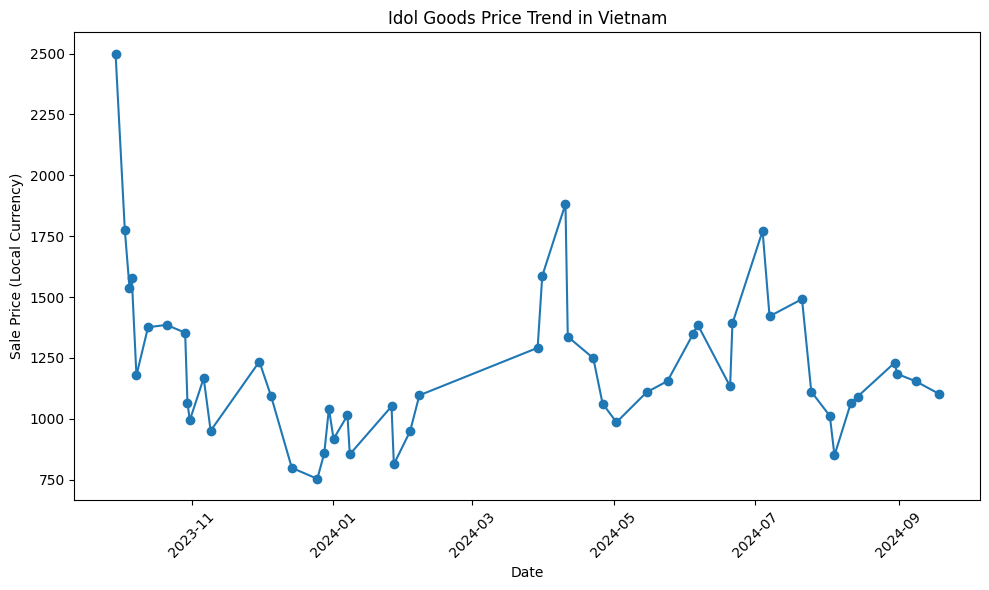


Top Trending Items in Thailand:
Idol Goods: Sale Price increased by 258.43%


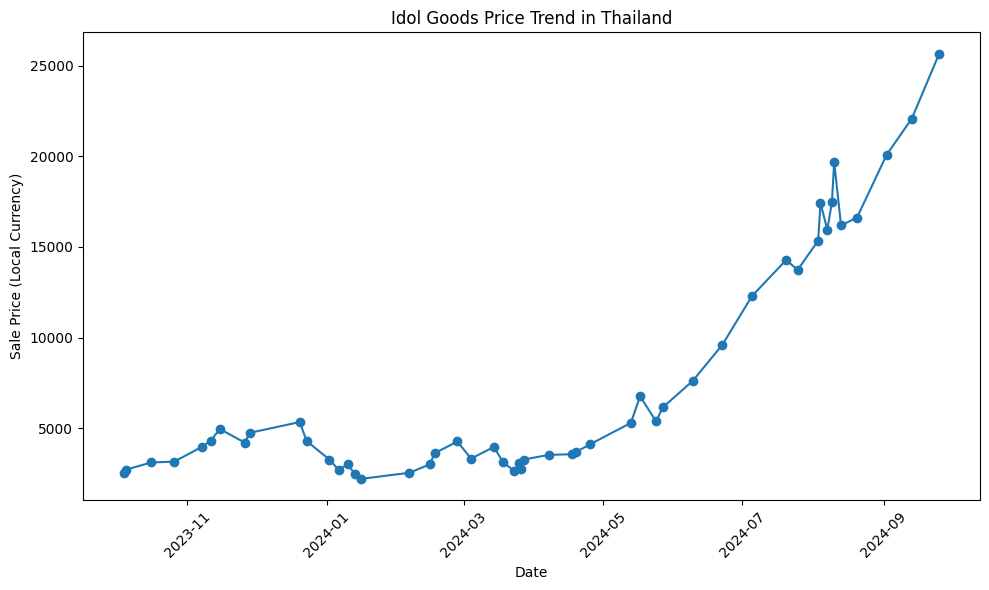

Digital Camera: Sale Price increased by -13.42%


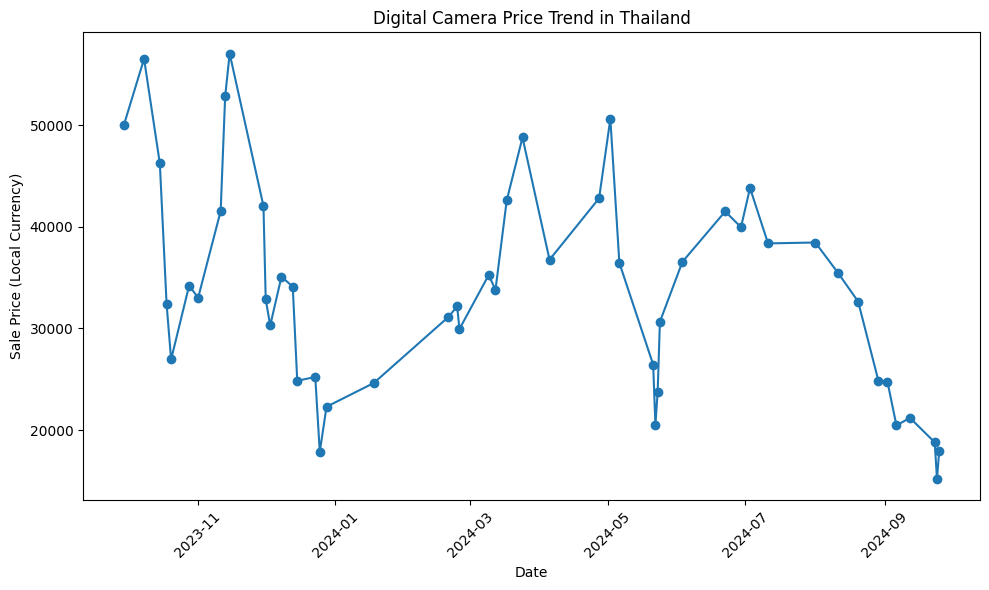

Plush Toys: Sale Price increased by -36.46%


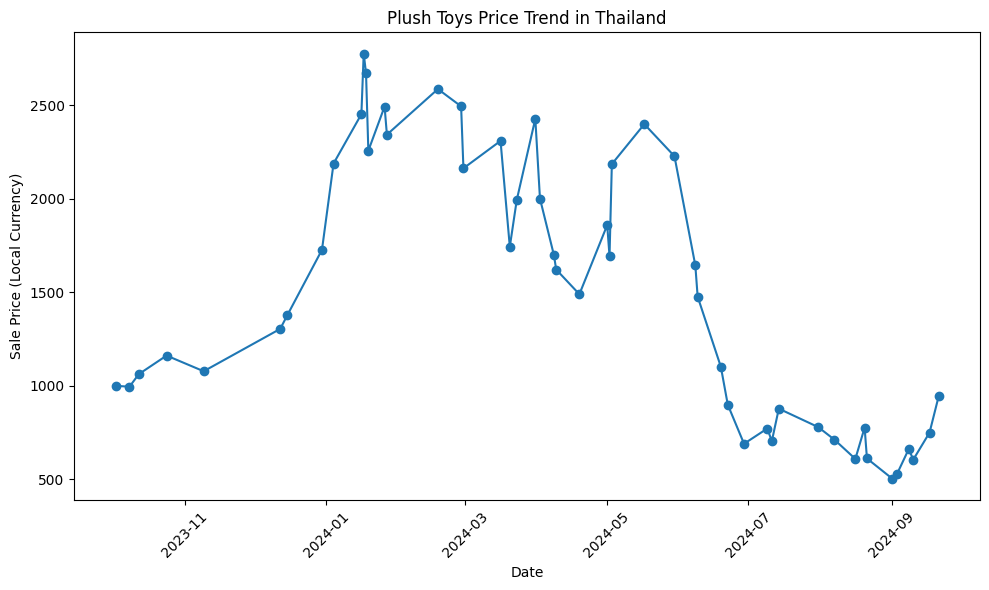


Top Trending Items in Malaysia:
Figures (Comic/Anime): Sale Price increased by 76.75%


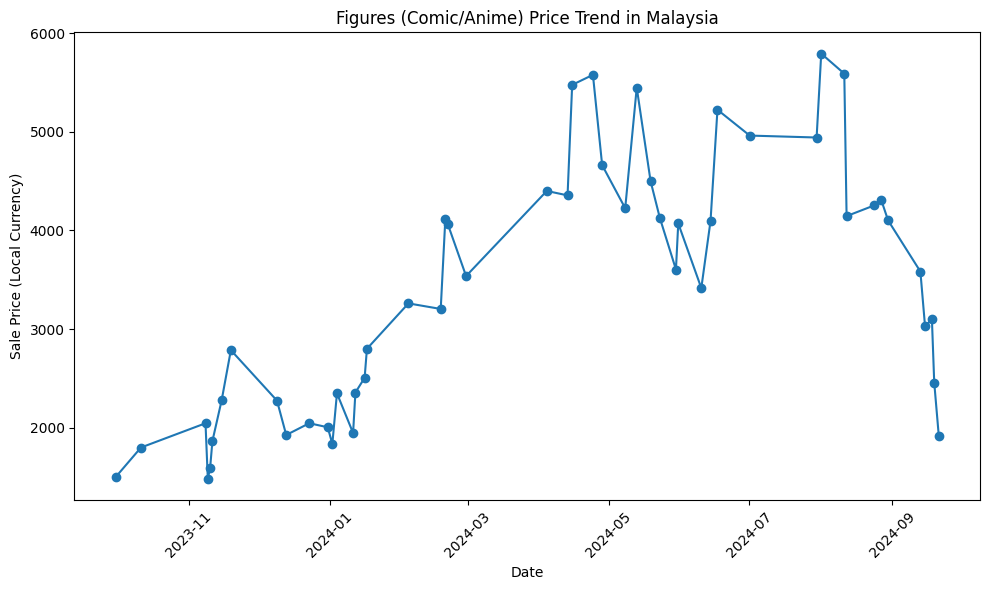

Pins/Badges: Sale Price increased by 46.64%


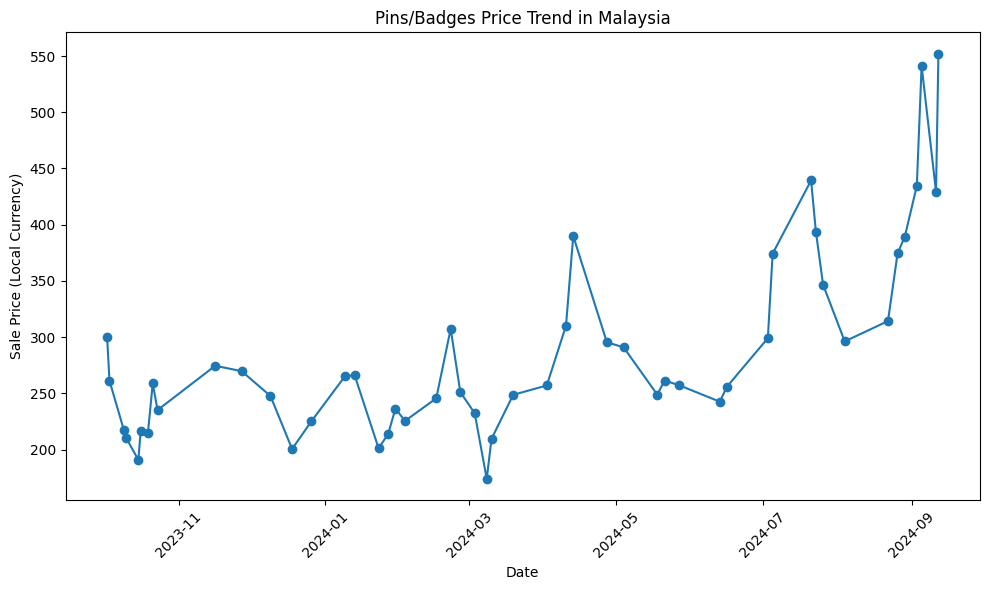

Ladies’ Bags: Sale Price increased by 24.40%


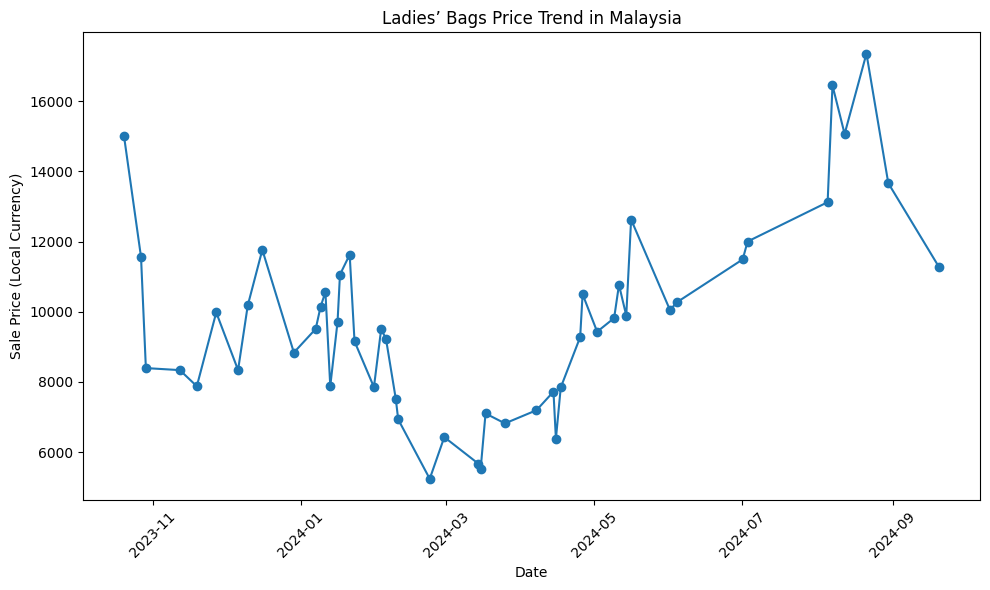


Top Trending Items in Indonesia:
Character Keychains: Sale Price increased by 157.32%


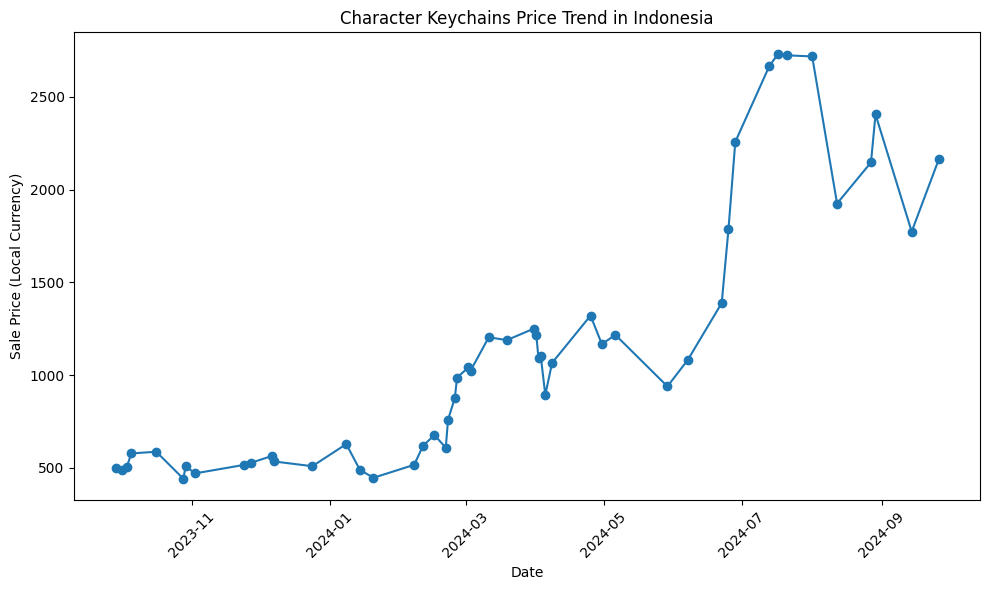

K-POP/Asia Goods: Sale Price increased by 42.89%


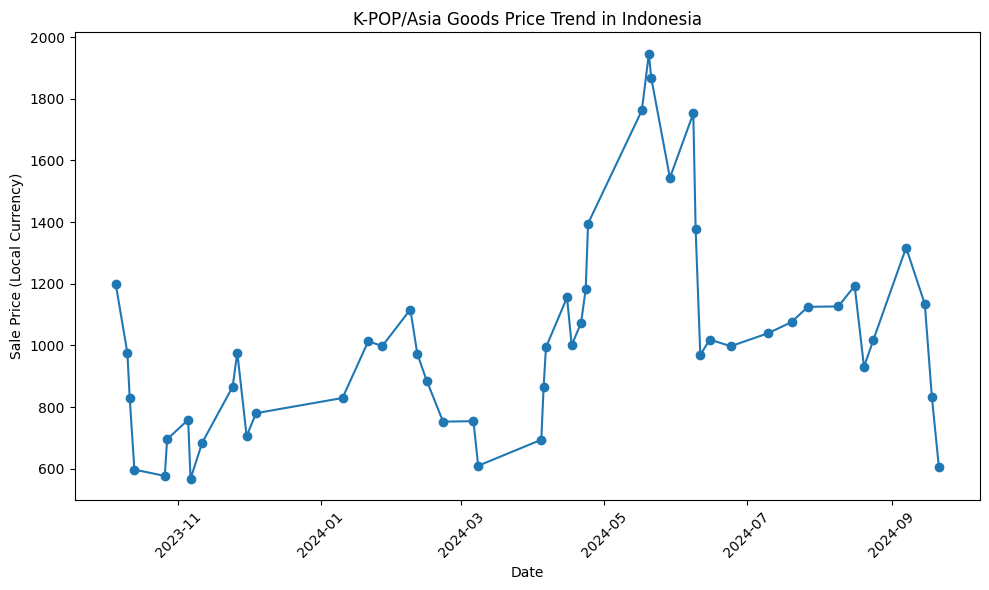

Plush Toys: Sale Price increased by 5.42%


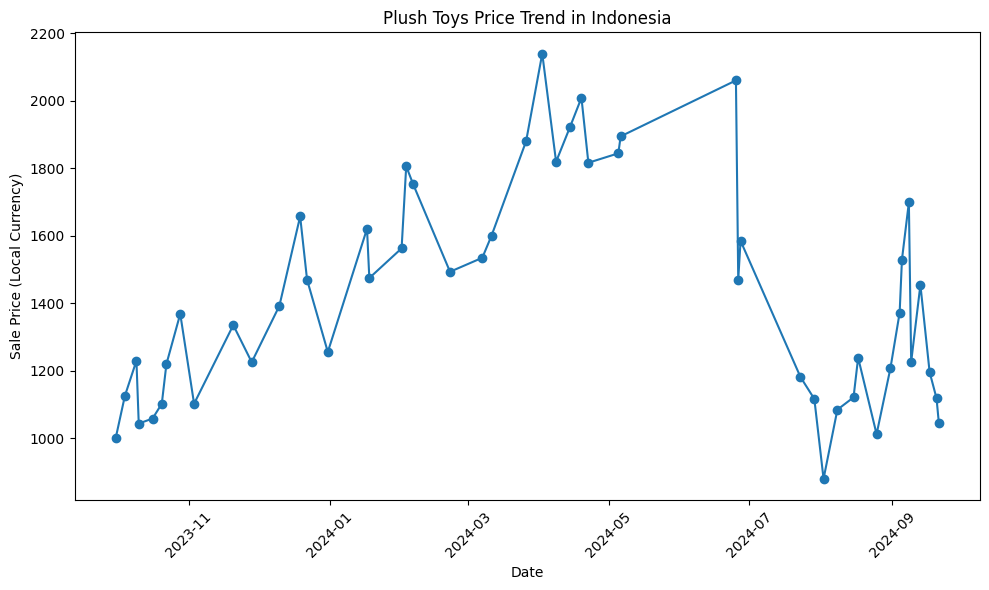


Top Trending Items in Philippines:
Character Keychains: Sale Price increased by 192.69%


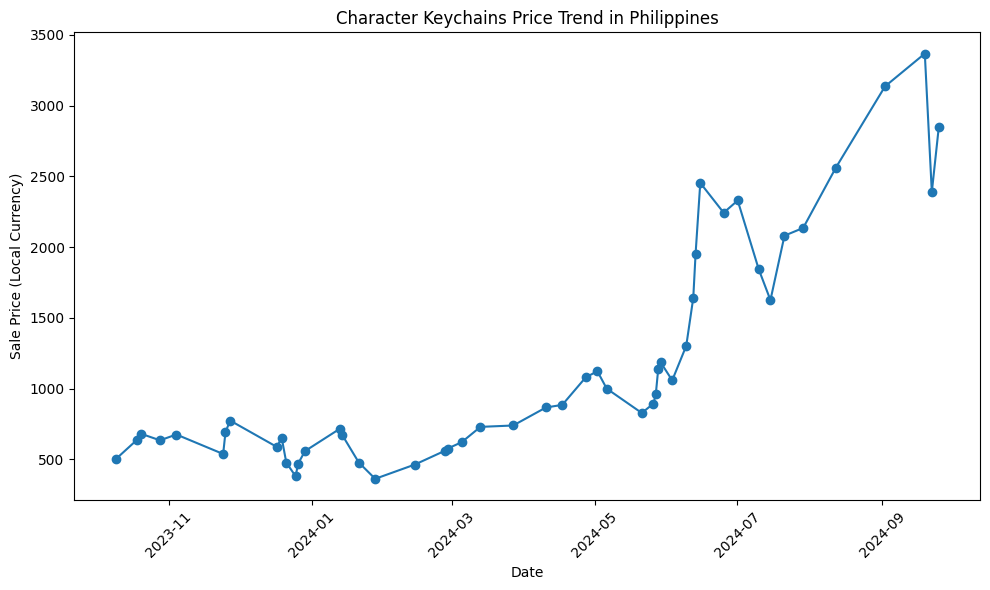

Acrylic Stands: Sale Price increased by 134.58%


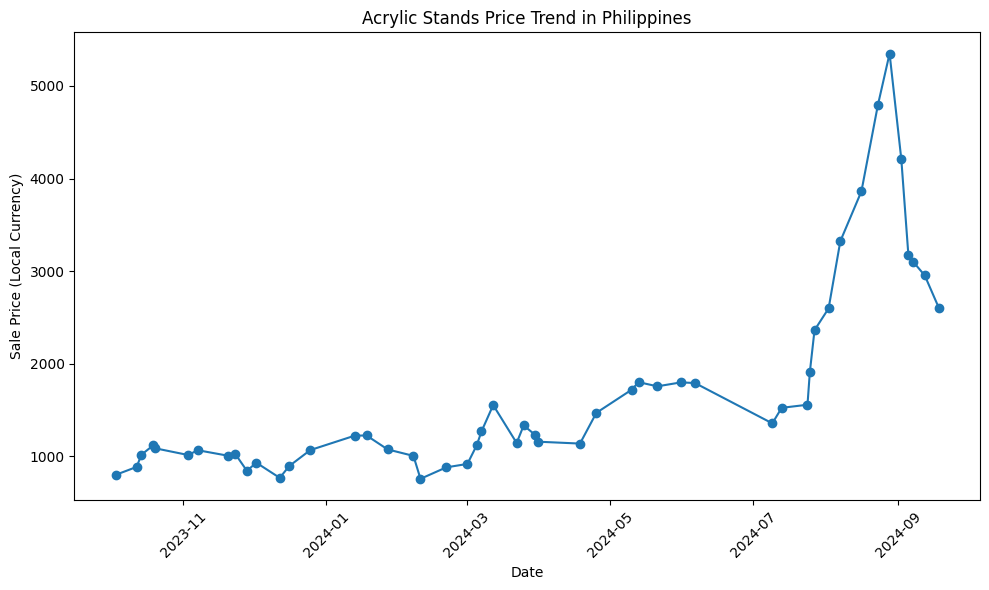

Pins/Badges: Sale Price increased by 99.81%


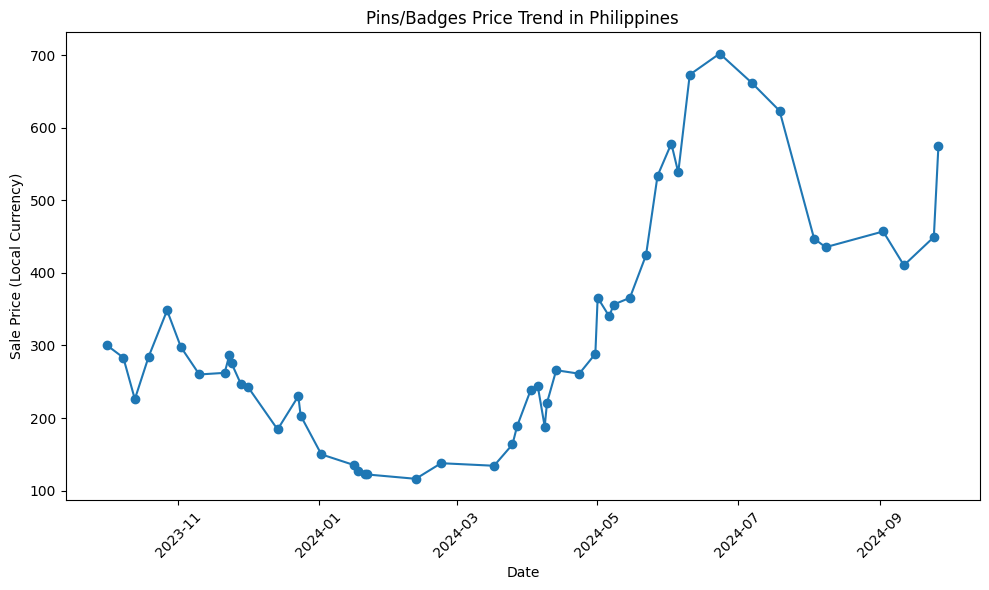


Is it a good time to buy Digital Camera in Japan? False
The current market conditions do not indicate a significant advantage for buying now.

Cultural Taboo Detection for China:
Detected taboos: []
AI Suggestions: No cultural taboos detected.

Communication Support for China:
AI Suggested Message: 你好! Thank you for your interest.

Sell Alert for Japan:
- Plush Toys
- Acrylic Stands
- Digital Camera

Sell Alert for China:
- Acrylic Stands
- Idol Goods
- Ladies’ Bags

Sell Alert for South Korea:
- Acrylic Stands
- Idol Goods
- K-POP/Asia Goods

Sell Alert for Vietnam:
- Ladies’ Bags
- Pins/Badges
- Plush Toys

Sell Alert for Thailand:
- Pokemon Cards
- Plush Toys
- Ladies’ Bags

Sell Alert for Malaysia:
- Figures (Comic/Anime)
- Idol Goods
- Plush Toys

Sell Alert for Indonesia:
- Character Keychains
- Pins/Badges
- Idol Goods

Sell Alert for Philippines:
- Plush Toys
- Acrylic Stands
- Pins/Badges


In [51]:
# Function to visualize price fluctuation for a specific item in all countries
def visualize_price_fluctuation_per_country(item_name):
    # Extract data for the specified item
    df_item = df[df['Item'] == item_name]
    # Get unique seller countries
    seller_countries = df_item['Seller Country'].unique()

    plt.figure(figsize=(12, 8))

    for country in seller_countries:
        df_country = df_item[df_item['Seller Country'] == country]
        df_country = df_country.sort_values(by='Date')
        plt.plot(df_country['Date'], df_country['Sale Price'], marker='o', linestyle='-', label=country)

    plt.title(f'{item_name} Price Fluctuation by Country')
    plt.xlabel('Date')
    plt.ylabel('Sale Price (Local Currency)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Updated function to recommend trending items with charts
def recommend_trending_items_with_charts():
    # Split data into past and recent periods
    df['Date'] = pd.to_datetime(df['Date'])
    median_date = df['Date'].median()
    df_recent = df[df['Date'] >= median_date]
    df_past = df[df['Date'] < median_date]

    trending_items = {}

    for country in countries:
        df_recent_country = df_recent[df_recent['Seller Country'] == country]
        df_past_country = df_past[df_past['Seller Country'] == country]

        recent_prices = df_recent_country.groupby('Item')['Sale Price'].mean()
        past_prices = df_past_country.groupby('Item')['Sale Price'].mean()

        price_change = ((recent_prices - past_prices) / past_prices) * 100
        price_change = price_change.dropna().sort_values(ascending=False)
        trending_items[country] = price_change.head(3)  # Top 3 items

    # Display trending items for each country with charts
    for country in trending_items:
        print(f'\nTop Trending Items in {country}:')
        for item, change in trending_items[country].items():
            print(f'{item}: Sale Price increased by {change:.2f}%')

            # Plot price trend for the item in this country
            df_item_country = df[(df['Item'] == item) & (df['Seller Country'] == country)]
            df_item_country = df_item_country.sort_values(by='Date')

            plt.figure(figsize=(10, 6))
            plt.plot(df_item_country['Date'], df_item_country['Sale Price'], marker='o', linestyle='-')
            plt.title(f'{item} Price Trend in {country}')
            plt.xlabel('Date')
            plt.ylabel('Sale Price (Local Currency)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Function to determine if it's a good time to buy an item
def is_good_time_to_buy(item_name, buyer_country):
    # Get recent data for the item
    df_item = df[(df['Item'] == item_name) & (df['Buyer Country'] == buyer_country)]
    if df_item.empty:
        return False, "No data available for this item and country."

    df_item = df_item.sort_values(by='Date')
    recent_price = df_item['Sale Price'].iloc[-1]

    # Calculate price change over the last 30 days
    one_month_ago = df_item['Date'].iloc[-1] - timedelta(days=30)
    df_one_month = df_item[df_item['Date'] >= one_month_ago]
    if len(df_one_month) < 2:
        return False, "Not enough recent data to analyze price trend."

    price_change = ((recent_price - df_one_month['Sale Price'].iloc[0]) / df_one_month['Sale Price'].iloc[0]) * 100

    # Get exchange rate data
    fx_series = fx_data_dict.get(buyer_country, None)
    if fx_series is not None:
        fx_series_recent = fx_series[fx_series.index >= one_month_ago]
        if len(fx_series_recent) >= 2:
            recent_fx = fx_series_recent.iloc[-1]
            fx_change = ((recent_fx - fx_series_recent.iloc[0]) / fx_series_recent.iloc[0]) * 100
        else:
            fx_change = 0
    else:
        fx_change = 0

    # Determine if it's a good time to buy
    if price_change < -5 or fx_change < -2:
        explanation = generate_ai_explanation(item_name, price_change, fx_change)
        return True, explanation
    else:
        return False, "The current market conditions do not indicate a significant advantage for buying now."

# Function to generate AI explanation (simulated)
def generate_ai_explanation(item_name, price_change, fx_change):
    explanation = f"AI Analysis: The price of {item_name} has decreased by {abs(price_change):.2f}% in the last month, "
    if fx_change != 0:
        explanation += f"and the exchange rate has changed by {abs(fx_change):.2f}% in your favor. "
    explanation += "This suggests that now is a good time to purchase this item. (Note: This analysis is AI-generated.)"
    return explanation

# Function to visualize price and exchange rate trends
def visualize_price_and_fx(item_name, buyer_country):
    # Get data for the item and country
    df_item = df[(df['Item'] == item_name) & (df['Buyer Country'] == buyer_country)]
    if df_item.empty:
        print("No data available for visualization.")
        return

    df_item = df_item.sort_values(by='Date')

    # Get exchange rate data
    fx_series = fx_data_dict.get(buyer_country, None)
    if fx_series is not None:
        fx_series = fx_series[fx_series.index >= df_item['Date'].min()]
    else:
        print("No exchange rate data available.")
        return

    # Plot price and exchange rate trends
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sale Price (Local Currency)', color='tab:red')
    ax1.plot(df_item['Date'], df_item['Sale Price'], color='tab:red', marker='o', label='Sale Price')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Exchange Rate (against USD)', color='tab:blue')
    ax2.plot(fx_series.index, fx_series.values, color='tab:blue', linestyle='--', label='Exchange Rate')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'{item_name} Price and Exchange Rate Trends in {buyer_country}')
    fig.tight_layout()
    plt.show()

# Function to detect cultural taboos in product descriptions (simulated)
def detect_cultural_taboos(description, country):
    # Simulate taboo detection
    taboos = {
        'Japan': ['number 4', 'white lilies'],
        'China': ['number 4', 'clocks'],
        'South Korea': ['red ink names'],
        # Add more taboos per country
    }
    detected_taboos = []
    for taboo in taboos.get(country, []):
        if taboo.lower() in description.lower():
            detected_taboos.append(taboo)
    return detected_taboos

# Function to suggest corrections using AI (simulated)
def suggest_corrections(description, detected_taboos):
    if detected_taboos:
        corrections = f"Please avoid mentioning {', '.join(detected_taboos)} as they are considered inappropriate in the target culture."
    else:
        corrections = "No cultural taboos detected."
    return corrections

# Communication support function (simulated)
def communication_support(country):
    greetings = {
        'Japan': 'こんにちは',
        'China': '你好',
        'South Korea': '안녕하세요',
        'Vietnam': 'Xin chào',
        # Add more greetings per country
    }
    message = greetings.get(country, 'Hello') + "! Thank you for your interest."
    return message

# Function to generate sell alerts
def sell_alerts():
    # Analyze items with increasing prices or transaction volumes
    df['Date'] = pd.to_datetime(df['Date'])
    one_month_ago = df['Date'].max() - timedelta(days=30)
    df_recent = df[df['Date'] >= one_month_ago]

    sell_recommendations = {}

    for country in countries:
        df_country = df_recent[df_recent['Buyer Country'] == country]
        if df_country.empty:
            continue
        transaction_counts = df_country['Item'].value_counts()
        top_items = transaction_counts.head(3).index.tolist()
        sell_recommendations[country] = top_items

    # Display sell recommendations
    for country, items_list in sell_recommendations.items():
        print(f'\nSell Alert for {country}:')
        for item in items_list:
            print(f'- {item}')

# Example usage:

# 1. Visualize price fluctuation for a specific item in all countries
visualize_price_fluctuation_per_country('Acrylic Stands')

# 2. Recommend trending items with charts
recommend_trending_items_with_charts()

# 3. Determine if it's a good time to buy an item
item_to_check = 'Digital Camera'
buyer_country = 'Japan'
is_good_time, explanation = is_good_time_to_buy(item_to_check, buyer_country)
print(f'\nIs it a good time to buy {item_to_check} in {buyer_country}? {is_good_time}')
if is_good_time:
    print(explanation)
    visualize_price_and_fx(item_to_check, buyer_country)
else:
    print(explanation)

# 4. Detect cultural taboos in product description
sample_description = "This clock is a perfect gift."
country = 'China'
detected = detect_cultural_taboos(sample_description, country)
corrections = suggest_corrections(sample_description, detected)
print(f'\nCultural Taboo Detection for {country}:')
print(f'Detected taboos: {detected}')
print(f'AI Suggestions: {corrections}')

# Communication support example
message = communication_support(country)
print(f'\nCommunication Support for {country}:')
print(f'AI Suggested Message: {message}')

# 5. Generate sell alerts
sell_alerts()


##